<a href="https://colab.research.google.com/github/Kryptera-K/DASH-QQE-Vol-Decline-Momentum-QVM-Strategy/blob/main/DASH_%5B'QQE_Value1_CrossAbove_Value2'%2C_'AvgVol_Falling'%2C_%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "DASH"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("DASH_clean.csv", index=False)
df

/tmp/ipython-input-1037024586.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2020-12-09,189.509995,195.500000,163.800003,182.000000,25373700
2020-12-10,186.000000,187.695007,172.636002,179.710007,9307600
2020-12-11,175.000000,182.000000,168.250000,176.520004,4760600
2020-12-14,160.000000,170.000000,151.199997,169.100006,7859600
2020-12-15,158.889999,161.419998,153.759995,157.100006,5017000
...,...,...,...,...,...
2025-10-06,281.739990,282.920013,273.679993,274.529999,3905100
2025-10-07,276.779999,285.079987,271.834991,283.149994,2863400
2025-10-08,281.049988,281.630005,277.440002,277.730011,2390900


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

AVG_VOL_PERIOD = 20
AVG_VOL_SHIFT = 10
QQE_FACTOR = 4.236
QQE_LEVEL = 50
QQE_PERIOD = 14
QQE_SHIFT = 5
QQE_SMOOTH = 5
RSI_OVERBOUGHT_LEVEL = 70
RSI_OVERSOLD_LEVEL = 30
RSI_PERIOD = 14
RSI_SHIFT = 5
RSI_SHIFT_2 = 10
WMA_PERIOD = 20
WMA_SHIFT = 5

# -------------------------
# Indicator Functions
# -------------------------

def qqe_cross_above_value2(df):
    df = calculate_qqe(df)
    return (df['QQE_Value1'] > df['QQE_Value2']) & (df['QQE_Value1'].shift(1) <= df['QQE_Value2'].shift(1))


def calculate_qqe(df, rsi_period=QQE_PERIOD, smooth=QQE_SMOOTH, factor=QQE_FACTOR):
    """
    Calculate QQE lines (Value1 & Value2) based on RSI smoothing and ATR-like smoothing.
    """
    df = df.copy()

    # --- RSI ---
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/rsi_period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/rsi_period, adjust=False).mean()
    rsi = 100 - (100 / (1 + roll_up / roll_down))

    # --- Smoothed RSI ---
    rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')

    # --- RSI Delta & ATR-like smoothing ---
    rsi_delta = rsi_ma.diff().abs().fillna(0)
    atr_rsi = rsi_delta.ewm(alpha=1/smooth, adjust=False).mean()

    # --- QQE Calculation ---
    value1 = rsi_ma.copy()
    value2 = pd.Series(index=df.index, dtype=float)
    value2.iloc[0] = value1.iloc[0]

    for i in range(1, len(df)):
        prev_trail = value2.iloc[i-1]
        prev_value1 = value1.iloc[i-1]
        atr = atr_rsi.iloc[i]
        direction = 1 if prev_value1 > prev_trail else -1
        value2.iloc[i] = prev_trail + direction * factor * atr

    df['QQE_Value1'] = value1
    df['QQE_Value2'] = value2

    return df


def avg_volume_is_falling(df, period=AVG_VOL_PERIOD, shift=AVG_VOL_SHIFT):
    df = calculate_avg_volume(df, period)
    return df['AvgVolume'] < df['AvgVolume'].shift(shift)


def calculate_avg_volume(df, period=AVG_VOL_PERIOD):
    """
    Calculate Average Volume
    df : pandas DataFrame with 'Volume' column
    period : lookback period
    """
    df = df.copy()
    df['AvgVolume'] = df['Volume'].rolling(window=period, min_periods=1).mean()
    return df


def wma_rising(df, shift=WMA_SHIFT, period=WMA_PERIOD):
    df = calculate_wma(df, period)
    return df['WMA'] > df['WMA'].shift(shift)


def calculate_wma(df, period=WMA_PERIOD):
    """
    Calculate Weighted Moving Average (WMA) for the Close price
    and add it as a column to the DataFrame.
    """
    df = df.copy()
    weights = np.arange(1, period + 1)
    df['WMA'] = df['Close'].rolling(period).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    return df


def rsi_lower_than_ob(df, level=RSI_OVERBOUGHT_LEVEL):
    df = calculate_rsi(df)
    return df['RSI'] < level


def calculate_rsi(df, period=RSI_PERIOD):
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(span=period, adjust=False).mean()
    roll_down = down.ewm(span=period, adjust=False).mean()
    rs = roll_up / roll_down
    df['RSI'] = 100 - (100 / (1 + rs))
    return df



# -------------------------
# Entry conditions
# -------------------------

df["QQE_Value1_CrossAbove_Value2"] = qqe_cross_above_value2(df)
df["AvgVol_Falling"] = avg_volume_is_falling(df)

# -------------------------
# Exit conditions
# -------------------------

df["WMA_Rising"] = wma_rising(df)
df["RSI_Lower_Than_OB"] = rsi_lower_than_ob(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'QQE_Value1_CrossAbove_Value2',
    'AvgVol_Falling',
]
exit_conditions = [
    'WMA_Rising',
    'RSI_Lower_Than_OB',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

/tmp/ipython-input-3626483996.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')


Start                               2020-12-09 00:00:00
End                                 2025-10-10 00:00:00
Period                               1215 days 00:00:00
Start Value                                    100000.0
End Value                                 224626.751291
Total Return [%]                             124.626751
Benchmark Return [%]                          50.763744
Max Gross Exposure [%]                            100.0
Total Fees Paid                            21056.760935
Max Drawdown [%]                              67.459546
Max Drawdown Duration                 979 days 00:00:00
Total Trades                                         56
Total Closed Trades                                  56
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  55.357143
Best Trade [%]                                20.657496
Worst Trade [%]                              -34

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2020-12-09 00:00:00
End                           2025-10-10 00:00:00
Period                         1215 days 00:00:00
Start Value                              100000.0
End Value                           150763.744312
Total Return [%]                        50.763744
Benchmark Return [%]                    50.763744
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        82.223659
Max Drawdown Duration           907 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                       50763.744312
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-208442742.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-208442742.py:71: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



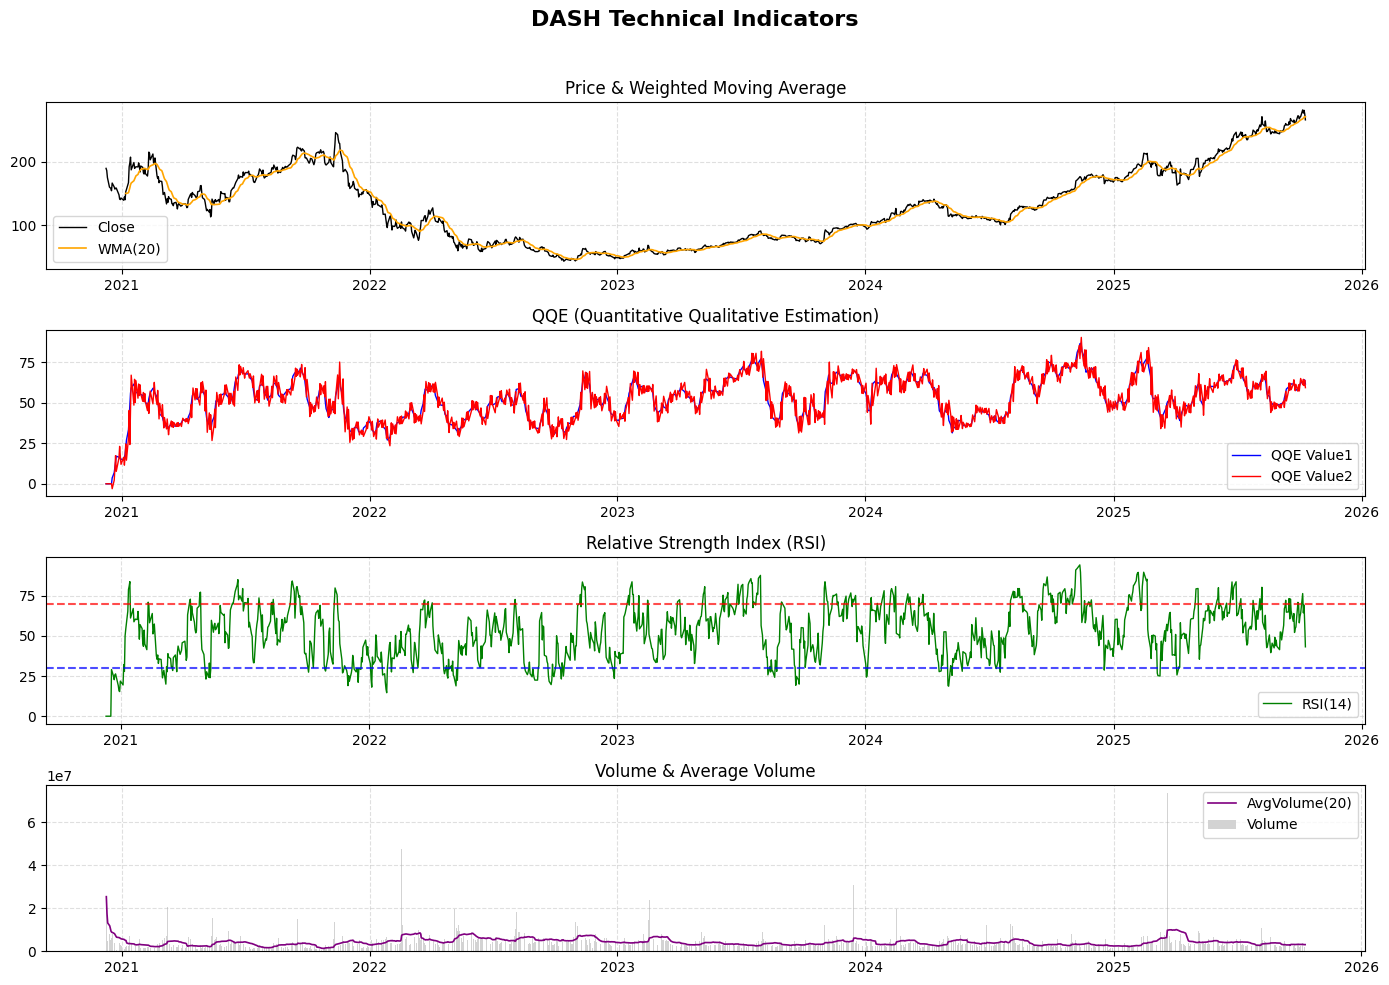

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------

symbol = "DASH"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.dropna(inplace=True)

# -------------------------
# Parameters
# -------------------------

AVG_VOL_PERIOD = 20
AVG_VOL_SHIFT = 10
QQE_FACTOR = 4.236
QQE_LEVEL = 50
QQE_PERIOD = 14
QQE_SHIFT = 5
QQE_SMOOTH = 5
RSI_OVERBOUGHT_LEVEL = 70
RSI_OVERSOLD_LEVEL = 30
RSI_PERIOD = 14
RSI_SHIFT = 5
RSI_SHIFT_2 = 10
WMA_PERIOD = 20
WMA_SHIFT = 5

# -------------------------
# Indicator Functions
# -------------------------

def calculate_rsi(df, period=RSI_PERIOD):
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(span=period, adjust=False).mean()
    roll_down = down.ewm(span=period, adjust=False).mean()
    rs = roll_up / roll_down
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

def calculate_wma(df, period=WMA_PERIOD):
    weights = np.arange(1, period + 1)
    df['WMA'] = df['Close'].rolling(period).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    return df

def calculate_avg_volume(df, period=AVG_VOL_PERIOD):
    df['AvgVolume'] = df['Volume'].rolling(window=period, min_periods=1).mean()
    return df

def calculate_qqe(df, rsi_period=QQE_PERIOD, smooth=QQE_SMOOTH, factor=QQE_FACTOR):
    df = df.copy()
    # --- RSI ---
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/rsi_period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/rsi_period, adjust=False).mean()
    rsi = 100 - (100 / (1 + roll_up / roll_down))

    # --- Smoothed RSI ---
    rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')

    # --- RSI Delta & ATR-like smoothing ---
    rsi_delta = rsi_ma.diff().abs().fillna(0)
    atr_rsi = rsi_delta.ewm(alpha=1/smooth, adjust=False).mean()

    # --- QQE Calculation ---
    value1 = rsi_ma.copy()
    value2 = pd.Series(index=df.index, dtype=float)
    value2.iloc[0] = value1.iloc[0]

    for i in range(1, len(df)):
        prev_trail = value2.iloc[i-1]
        prev_value1 = value1.iloc[i-1]
        atr = atr_rsi.iloc[i]
        direction = 1 if prev_value1 > prev_trail else -1
        value2.iloc[i] = prev_trail + direction * factor * atr

    df['QQE_Value1'] = value1
    df['QQE_Value2'] = value2

    return df

# -------------------------
# Calculate Indicators
# -------------------------

df = calculate_rsi(df)
df = calculate_wma(df)
df = calculate_avg_volume(df)
df = calculate_qqe(df)

# -------------------------
# Plot
# -------------------------

plt.figure(figsize=(14, 10))
plt.suptitle(f"{symbol} Technical Indicators", fontsize=16, fontweight="bold")

# --- Price + WMA ---
plt.subplot(4, 1, 1)
plt.plot(df['Close'], label='Close', color='black', linewidth=1)
plt.plot(df['WMA'], label=f'WMA({WMA_PERIOD})', color='orange', linewidth=1.2)
plt.title("Price & Weighted Moving Average")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# --- QQE ---
plt.subplot(4, 1, 2)
plt.plot(df['QQE_Value1'], label='QQE Value1', color='blue', linewidth=1)
plt.plot(df['QQE_Value2'], label='QQE Value2', color='red', linewidth=1)
plt.title("QQE (Quantitative Qualitative Estimation)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# --- RSI ---
plt.subplot(4, 1, 3)
plt.plot(df['RSI'], label=f'RSI({RSI_PERIOD})', color='green', linewidth=1)
plt.axhline(RSI_OVERBOUGHT_LEVEL, color='red', linestyle='--', alpha=0.7)
plt.axhline(RSI_OVERSOLD_LEVEL, color='blue', linestyle='--', alpha=0.7)
plt.title("Relative Strength Index (RSI)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# --- Volume + Avg Volume ---
plt.subplot(4, 1, 4)
plt.bar(df.index, df['Volume'], label='Volume', color='lightgray')
plt.plot(df['AvgVolume'], label=f'AvgVolume({AVG_VOL_PERIOD})', color='purple', linewidth=1.2)
plt.title("Volume & Average Volume")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
